# Automotive industry sites

In [1]:
import pandas as pd
import numpy as np
from shapely.ops import transform

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.offsetbox import AnchoredText

from pynsee import *

In [2]:
# get activity list
naf5 = get_activity_list('NAF5')

# search data in SIRENE database
data = search_sirene(variable="activitePrincipaleEtablissement",
                     pattern='29.10Z', kind='siret', number=2000)

In [3]:
data.to_csv('sirene.csv')

In [4]:
data.head()

,siren,nic,siret,dateDebut,dateCreationEtablissement,dateCreationUniteLegale,dateFin,denominationUniteLegale,nomUniteLegale,prenomUsuelUniteLegale,...,libelleVoie2Etablissement,codePostal2Etablissement,libelleCommune2Etablissement,libelleCommuneEtranger2Etablissement,distributionSpeciale2Etablissement,codeCommune2Etablissement,codeCedex2Etablissement,libelleCedex2Etablissement,codePaysEtranger2Etablissement,libellePaysEtranger2Etablissement
0,006580195,00011,00658019500011,2008-01-01,1965-01-01,1965-01-01,None,SOCIETE INDUSTRIELLE POUR LE DEVELOPPEMENT DE ...,None,None,...,None,None,None,None,None,None,None,None,None,None
1,085520195,00109,08552019500109,2022-09-01,2022-06-30,1955-01-01,None,SAFRA,None,None,...,None,None,None,None,None,None,None,None,None,None
2,301692307,00020,30169230700020,2020-12-31,2014-08-15,1965-01-01,None,GARAGE BEYRIS,None,None,...,None,None,None,None,None,None,None,None,None,None
3,302279229,00025,30227922900025,2014-07-25,1900-01-01,1975-01-01,None,RAPIDO,None,None,...,None,None,None,None,None,None,None,None,None,None
4,302279229,00033,30227922900033,2008-01-01,1996-01-01,1975-01-01,None,RAPIDO,None,None,...,None,None,None,None,None,None,None,None,None,None


In [5]:
# keep only businesses with more then 100 employees
df = data.loc[data['effectifsMinEtablissement'] > 100]
df = df.reset_index(drop=True)
# find latitude and longitude of all businesses
gdf = df.get_location().sort_values(by=['effectifsMinEtablissement'], ascending=False)

For at least one point, exact location has not been found, city location has been given instead                                                   | 0/49 [00:00<?, ?it/s]
Getting location: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 571.33it/s]


In [6]:
# get map - departement limits
geodataList =  get_geodata_list()
mapdep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement', update=True)
mapdep = mapdep.transform_overseas()
mapdep.head()

,geometry,id,nom_m,nom,insee_dep,insee_reg
0,"MULTIPOLYGON (((533820.757 5815685.538, 533972...",DEPARTEM_FXX_00000000001,AIN,Ain,01,84
1,"MULTIPOLYGON (((347405.807 6395467.47, 347374....",DEPARTEM_FXX_00000000002,AISNE,Aisne,02,32
2,"MULTIPOLYGON (((1046859.484 5315956.073, 10468...",DEPARTEM_FXX_00000000003,HAUTE-CORSE,Haute-Corse,2B,94
3,"MULTIPOLYGON (((955740.729 5142374.305, 955755...",DEPARTEM_FXX_00000000004,CORSE-DU-SUD,Corse-du-Sud,2A,94
4,"MULTIPOLYGON (((282378.517 5864026.958, 282436...",DEPARTEM_FXX_00000000005,ALLIER,Allier,03,84


In [7]:
# make cleaned labels
match_list = ['RENAULT SAS', 'ALPINE', 'BATILLY', 'MAUBEUGE CONSTRUCTION',
              'TOYOTA', 'STELLANTIS AUTO SAS', 'RENAULT TRUCKS']
other_string_list = '|'.join(['[^' + x + ']' for x in match_list])

conditions = [gdf['denominationUniteLegale'].str.contains(x) for x in match_list]
conditions += [gdf['denominationUniteLegale'].str.contains(other_string_list)]

values = ['RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS',
          'TOYOTA', 'STELLANTIS AUTO SAS', 'RENAULT TRUCKS', 'OTHER']

gdf['label'] = np.select(conditions, values)

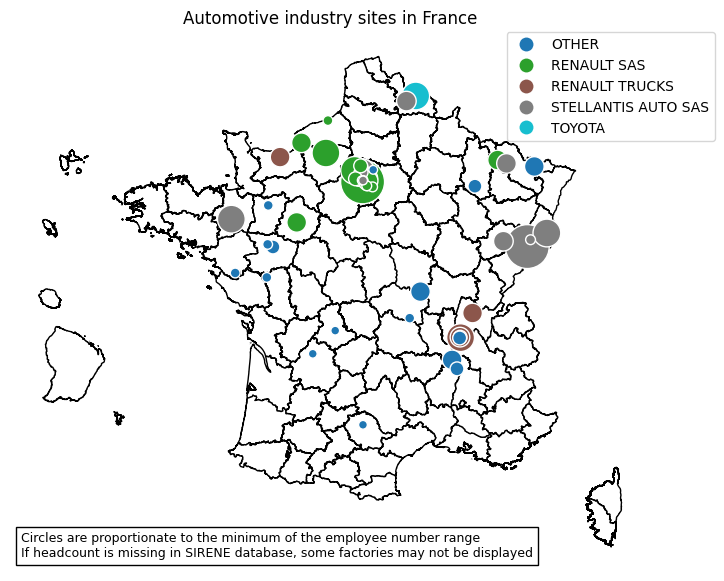

In [8]:
# change projection
gdf = gdf.to_crs('EPSG:3857')
# annotation
txt = 'Circles are proportionate to the minimum of the employee number range'
txt += '\nIf headcount is missing in SIRENE database, some factories may not be displayed'

#plot
ax = mapdep.plot(color='white', edgecolor='black', figsize = (15,7))
plt.title('Automotive industry sites in France')
gdf.plot(ax=ax,
         column = 'label',
         edgecolor='white',
         markersize=gdf.effectifsMinEtablissement/5,
         legend=True,
         legend_kwds={'bbox_to_anchor': (1.1,1),
                       'loc':1, 'borderaxespad': 0})

at = AnchoredText(txt, prop=dict(size=9), frameon=True, loc='lower left')
ax.add_artist(at)
ax.set_axis_off()
plt.show()